In [1]:
import numpy as np
import matplotlib

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

	
# Set such that PDF fonts export in a manner that they
# are editable in illustrator/affinity
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# set to define axes linewidths
matplotlib.rcParams['axes.linewidth'] = 0.5

# this defines some prefactors so inline figures look nice
# on a retina macbook. These can be commented out without any
# issue and are solely asthetic.
%matplotlib inline
%config InlineBackend.figure_format='retina'

# UPDATE 2020-12-31 (my preferred font is Avenir...)
font = {'family' : 'avenir',
    	'weight' : 'normal'}

matplotlib.rc('font', **font)

from tqdm import tqdm
import pickle
from sparrow import Protein
import protfasta
import metapredict as meta
from scipy.signal import convolve2d

import metapredict as meta

import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN


from finches import Mpipi_frontend
mf = Mpipi_frontend()


## Domain decomposition notebook
NOTE: This is an area we are ACTIVELY working on (right now) to improve for an updated preprint. We have several approaches we're pursuing for optimized decomposition, so please expect this code to change in the coming weeks!

In [2]:
def extract_domains(seq1, seq2, thresh = 0.003, kernel_size=31):
    """
    Basic function that smooves the interaction matrix with a 
    size-defineable square kernel, and then manually assigns 
    columns to groups based on their distance. This is a very
    bad algorithm in that the order of column appearance will
    influence group assignment, so it does not scale well - we're
    using it right now as a proof of concept while active work on
    better ways to segment out chemically-distinct groups is worked
    on.

    Parameters
    ------------

    seq1 : str
        Main amino acid sequence of interest

    seq2 : str
        Guest sequence we're using to define domains with

    thresh : float
        Sensitivity with which different groups are defined

    kernel_size : int
        Size of smoothing kernel used before clustering is
        performed.

    Returns
    ------------    
    tuple

        ordered_groups: dict - dictionary where keys are group
            index and values are a list of lists where each sublist
            has each residue found within a contigous example of 
            the group in question
            
        all_boundaries: dict - dictionary where keys are group
            index and values are a list of lists that define start/end
            residues for grouped residues.
            
        smoothed_matrix: np.array - matrix with the smoothed array used
            for domain decomposition
            
        inter_matrix: np.array - original matrix used for input    
    """

    # 
    inter_matrix = mf.intermolecular_idr_matrix(seq1,seq2)[0][0]
    
    normalization_factor = np.power(kernel_size,2)
    
    kernel = np.ones((kernel_size, kernel_size)) / normalization_factor
    
    smoothed_matrix = convolve2d(inter_matrix, kernel, mode='same')

    # focus on top seq
    seqlen = inter_matrix.shape[0]
    length_norm = inter_matrix.shape[1]
    

    # initialize things
    all_indices = set(np.arange(0, seqlen))    
    gn = -1
    groups = {}

    # while any residues are unaccountaed
    tmp = []
    while len(all_indices) > 0:

        # start a new group
        gn = gn + 1

        # initialize membership
        groups[gn] = set([])

        # grab the first indix from the remaining induces (note order here does not matter
        j = list(all_indices)[0]

        # this residue is the founding member of the new group!
        groups[gn].add(j)          

        # now cycle over each residue not yet assigned to a group
        for i in all_indices:
            tmp.append(abs(np.mean(smoothed_matrix[j] - smoothed_matrix[i]))/length_norm )            
            if abs(np.mean(smoothed_matrix[j] - smoothed_matrix[i]))/length_norm < thresh:                
                groups[gn].add(i)
            

        all_indices = all_indices - groups[gn]

    print(np.mean(tmp))
    ordered_groups = {}
    for g in range(0,len(groups)):
        ordered_groups[g] = sorted(list(groups[g]))

    # decode boundaries
    all_boundaries = {}
    for gn in ordered_groups:
        vals = ordered_groups[gn]
    
        domain_boundaries = []
        start = vals[0]
        current = start
        for pos in vals[1:]:
    
            # carry on
            if pos == current + 1:
                current = pos
    
            # found a break
            else:
                domain_boundaries.append([start,current])
                start = pos
                current = pos
        domain_boundaries.append([start,current])
        all_boundaries[gn] = domain_boundaries    
        
    return ordered_groups, all_boundaries, smoothed_matrix, inter_matrix


In [3]:
sup35 = 'MSDSNQGNNQQNYQQYSQNGNQQQGNNRYQGYQAYNAQAQPAGGYYQNYQGYSGYQQGGYQQYNPDAGYQQQYNPQGGYQQYNPQGGYQQQFNPQGGRGNYKNFNYNNNLQGYQAGFQPQSQGMSLNDFQKQQKQAAPKPKKTLKLVSSSGIKLANATKKVGTKPAESDKKEEEKSAETKEPTKEPTKVEEPVKKEEKPVQTEEKTEEKSELPKVEDLKISESTHNTNNANVTSADALIKEQEEEVDDEVVNDMFGGKDHVSLIFMGHVDAGKSTMGGNLLYLTGSVDKRTIEKYEREAKDAGRQGWYLSWVMDTNKEERNDGKTIEVGKAYFETEKRRYTILDAPGHKMYVSEMIGGASQADVGVLVISARKGEYETGFERGGQTREHALLAKTQGVNKMVVVVNKMDDPTVNWSKERYDQCVSNVSNFLRAIGYNIKTDVVFMPVSGYSGANLKDHVDPKECPWYTGPTLLEYLDTMNHVDRHINAPFMLPIAAKMKDLGTIVEGKIESGHIKKGQSTLLMPNKTAVEIQNIYNETENEVDMAMCGEQVKLRIKGVEEEDISPGFVLTSPKNPIKSVTKFVAQIAIVELKSIIAAGFSCVMHVHTAIEEVHIVKLLHKLEKGTNRKSKKPPAFAKKGMKVIAVLETEAPVCVETYQDYPQLGRFTLRDQGTTIAIGKIVKIAE'
idr1 = meta.predict_disorder_domains(sup35).disordered_domains[0]

# define Sup35 domains
B = extract_domains(idr1,idr1, thresh=0.01)

0.006719638690624787


In [4]:
# start should be 125...
start = B[0][1][0]

(<Figure size 2975x2975 with 4 Axes>,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >)

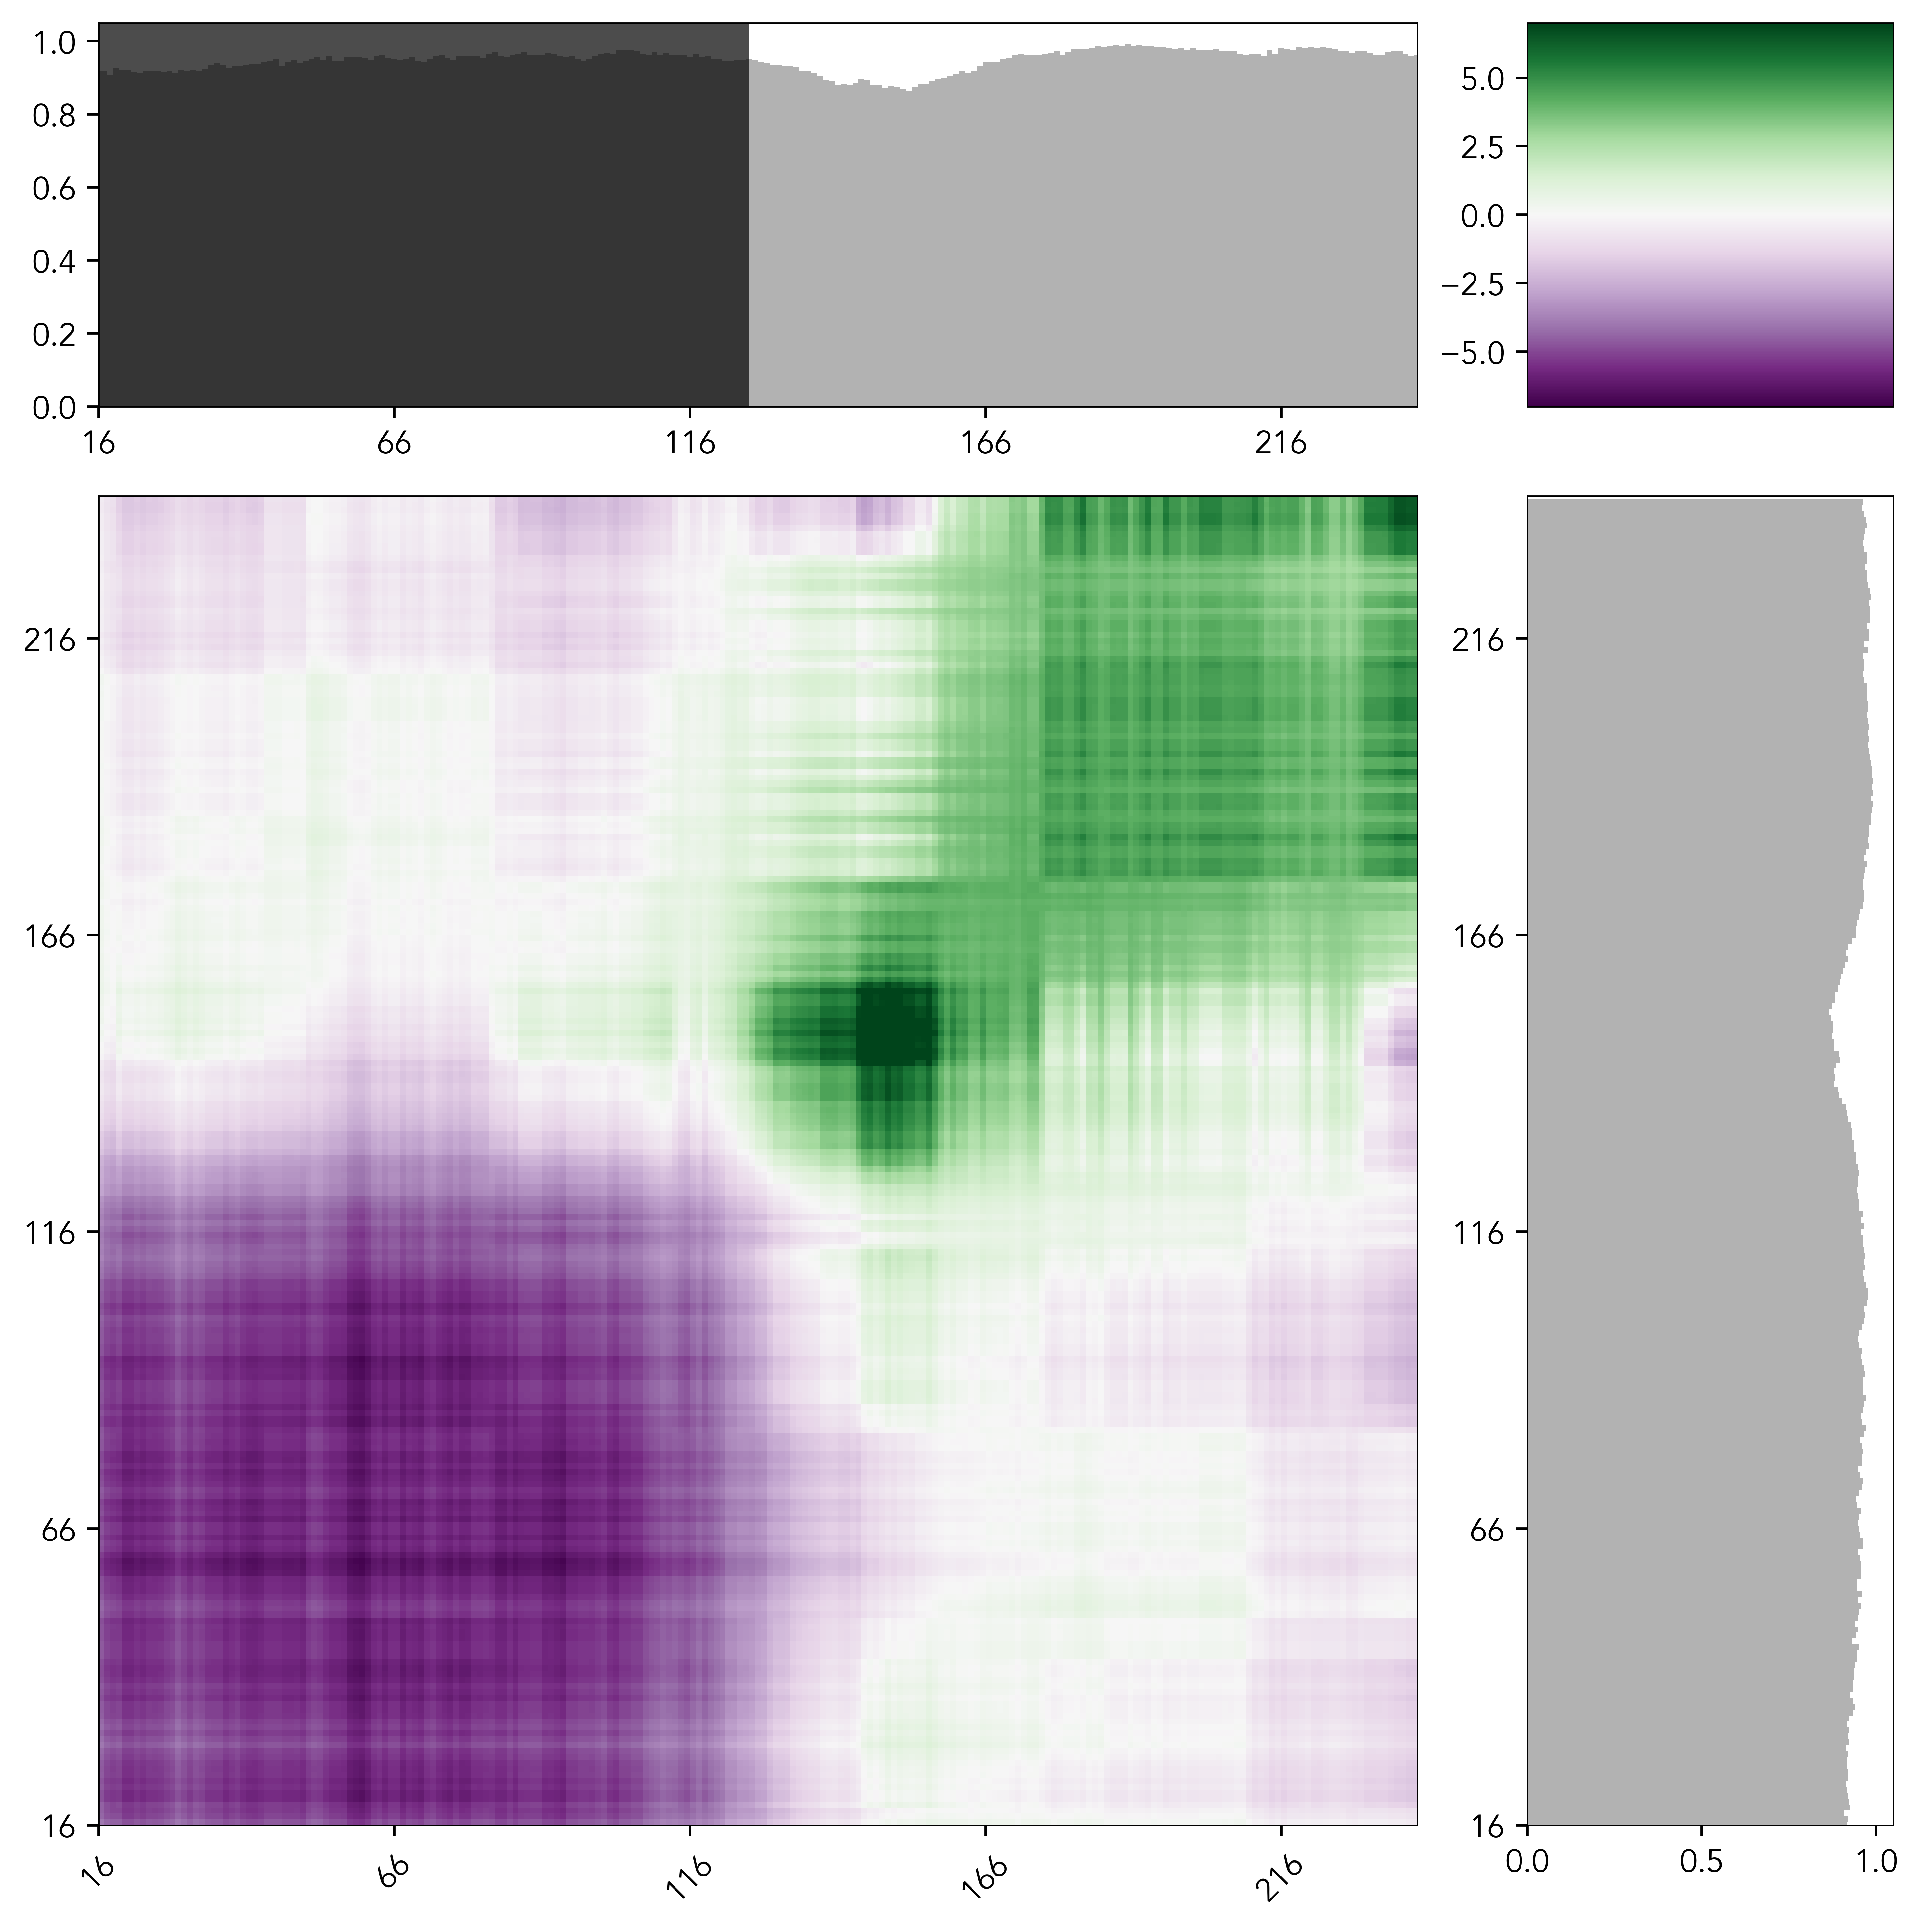

In [13]:
Protein(idr1).show_sequence()

# domain boundary drawn on here to manually then make look nice after (0-125)
mf.interaction_figure(idr1,idr1,fname='out_figures/sup35_idr12.pdf', vmin=-7, vmax=7, seq1_domains=[[0,start]], tic_frequency=50)

SGLNGAQMEKIPLLHISSCDQNISEKDLLDTENKRKKDFLTSENSLPRISSLPKSEKPLNEETVVNKRDEEQHLESHTDCILAVKQAISGTSPVASSFQGIKKSIFRIRESPKETFNASFSGHMTDPNFKKETEASESGLEIHTVCSQKEDSLCPNLIDNGSWPATTTQNSVALKNAGLISTLKKKTNKFIYAIHDETSY


(<Figure size 2975x2975 with 4 Axes>,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >)

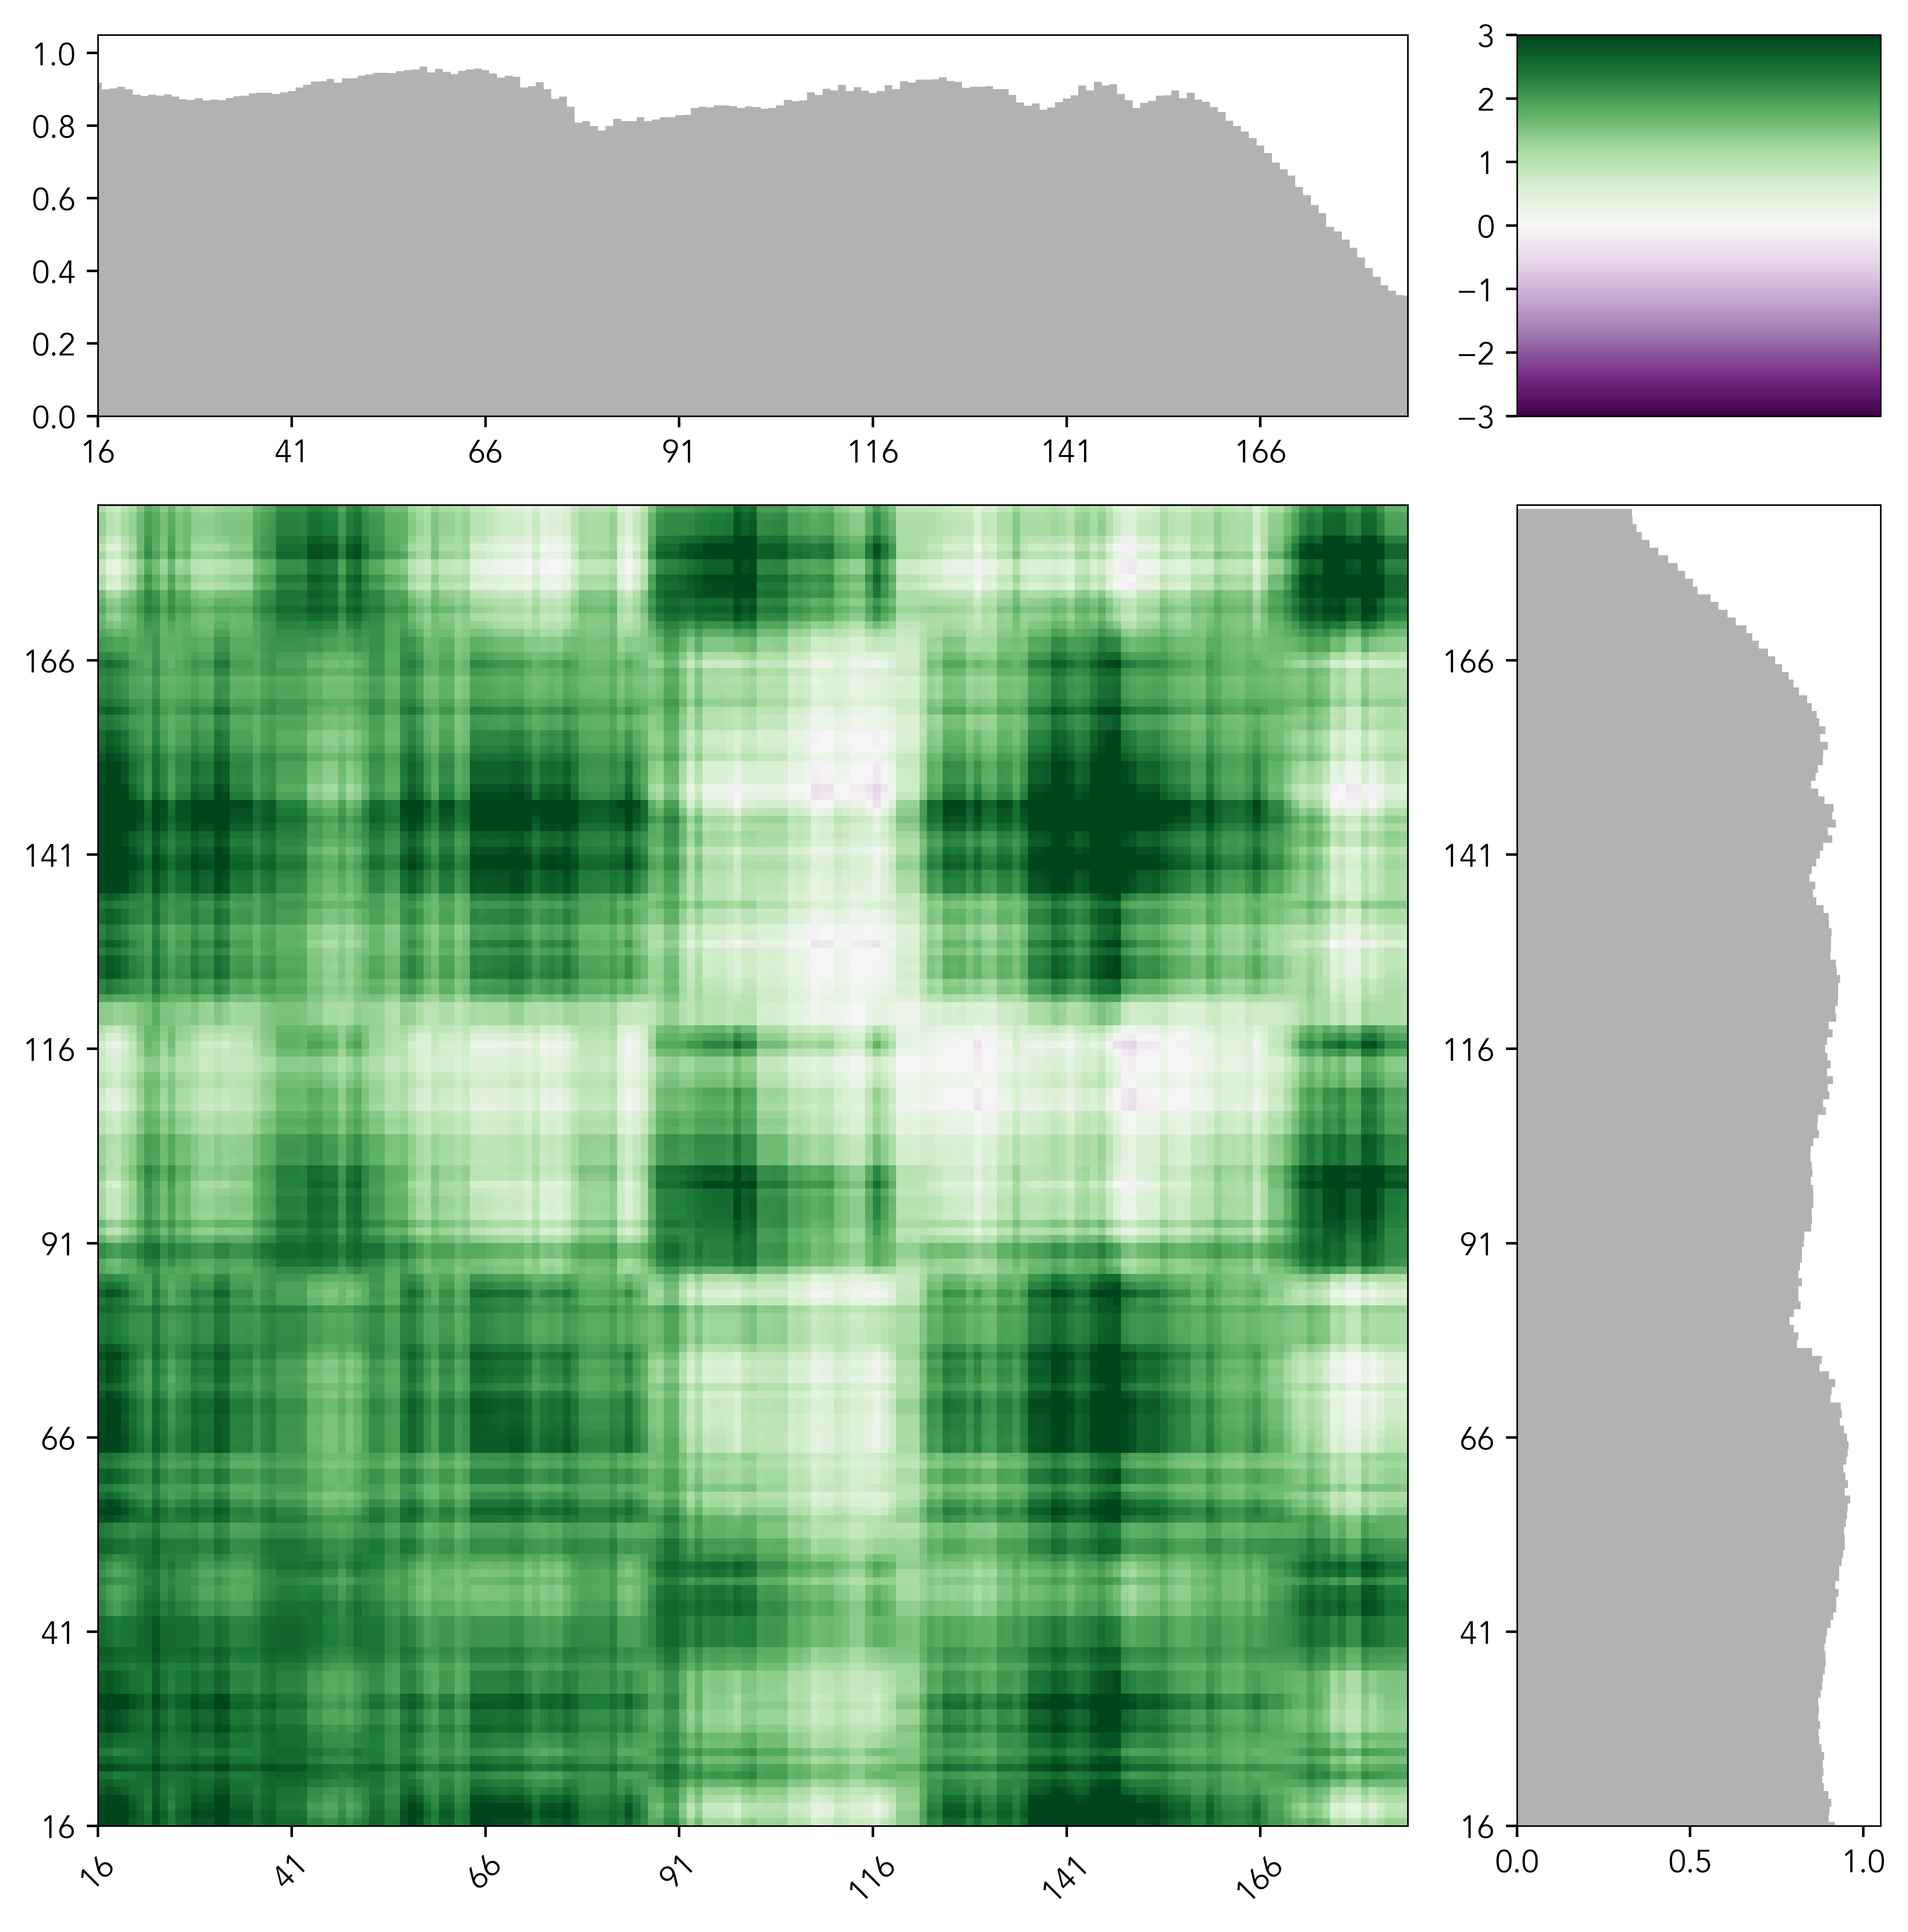

In [12]:
brca2 = 'MPIGSKERPTFFEIFKTRCNKADLGPISLNWFEELSSEAPPYNSEPAEESEHKNNNYEPNLFKTPQRKPSYNQLASTPIIFKEQGLTLPLYQSPVKELDKFKLDLGRNVPNSRHKSLRTVKTKMDQADDVSCPLLNSCLSESPVVLQCTHVTPQRDKSVVCGSLFHTPKFVKGRQTPKHISESLGAEVDPDMSWSSSLATPPTLSSTVLIVRNEEASETVFPHDTTANVKSYFSNHDESLKKNDRFIASVTDSENTNQREAASHGFGKTSGNSFKVNSCKDHIGKSMPNVLEDEVYETVVDTSEEDSFSLCFSKCRTKNLQKVRTSKTRKKIFHEANADECEKSKNQVKEKYSFVSEVEPNDTDPLDSNVANQKPFESGSDKISKEVVPSLACEWSQLTLSGLNGAQMEKIPLLHISSCDQNISEKDLLDTENKRKKDFLTSENSLPRISSLPKSEKPLNEETVVNKRDEEQHLESHTDCILAVKQAISGTSPVASSFQGIKKSIFRIRESPKETFNASFSGHMTDPNFKKETEASESGLEIHTVCSQKEDSLCPNLIDNGSWPATTTQNSVALKNAGLISTLKKKTNKFIYAIHDETSYKGKKIPKDQKSELINCSAQFEANAFEAPLTFANADSGLLHSSVKRSCSQNDSEEPTLSLTSSFGTILRKCSRNETCSNNTVISQDLDYKEAKCNKEKLQLFITPEADSLSCLQEGQCENDPKSKKVSDIKEEVLAAACHPVQHSKVEYSDTDFQSQKSLLYDHENASTLILTPTSKDVLSNLVMISRGKESYKMSDKLKGNNYESDVELTKNIPMEKNQDVCALNENYKNVELLPPEKYMRVASPSRKVQFNQNTNLRVIQKNQEETTSISKITVNPDSEELFSDNENNFVFQVANERNNLALGNTKELHETDLTCVNEPIFKNSTMVLYGDTGDKQATQVSIKKDLVYVLAEENKNSVKQHIKMTLGQDLKSDISLNIDKIPEKNNDYMNKWAGLLGPISNHSFGGSFRTASNKEIKLSEHNIKKSKMFFKDIEEQYPTSLACVEIVNTLALDNQKKLSKPQSINTVSAHLQSSVVVSDCKNSHITPQMLFSKQDFNSNHNLTPSQKAEITELSTILEESGSQFEFTQFRKPSYILQKSTFEVPENQMTILKTTSEECRDADLHVIMNAPSIGQVDSSKQFEGTVEIKRKFAGLLKNDCNKSASGYLTDENEVGFRGFYSAHGTKLNVSTEALQKAVKLFSDIENISEETSAEVHPISLSSSKCHDSVVSMFKIENHNDKTVSEKNNKCQLILQNNIEMTTGTFVEEITENYKRNTENEDNKYTAASRNSHNLEFDGSDSSKNDTVCIHKDETDLLFTDQHNICLKLSGQFMKEGNTQIKEDLSDLTFLEVAKAQEACHGNTSNKEQLTATKTEQNIKDFETSDTFFQTASGKNISVAKESFNKIVNFFDQKPEELHNFSLNSELHSDIRKNKMDILSYEETDIVKHKILKESVPVGTGNQLVTFQGQPERDEKIKEPTLLGFHTASGKKVKIAKESLDKVKNLFDEKEQGTSEITSFSHQWAKTLKYREACKDLELACETIEITAAPKCKEMQNSLNNDKNLVSIETVVPPKLLSDNLCRQTENLKTSKSIFLKVKVHENVEKETAKSPATCYTNQSPYSVIENSALAFYTSCSRKTSVSQTSLLEAKKWLREGIFDGQPERINTADYVGNYLYENNSNSTIAENDKNHLSEKQDTYLSNSSMSNSYSYHSDEVYNDSGYLSKNKLDSGIEPVLKNVEDQKNTSFSKVISNVKDANAYPQTVNEDICVEELVTSSSPCKNKNAAIKLSISNSNNFEVGPPAFRIASGKIVCVSHETIKKVKDIFTDSFSKVIKENNENKSKICQTKIMAGCYEALDDSEDILHNSLDNDECSTHSHKVFADIQSEEILQHNQNMSGLEKVSKISPCDVSLETSDICKCSIGKLHKSVSSANTCGIFSTASGKSVQVSDASLQNARQVFSEIEDSTKQVFSKVLFKSNEHSDQLTREENTAIRTPEHLISQKGFSYNVVNSSAFSGFSTASGKQVSILESSLHKVKGVLEEFDLIRTEHSLHYSPTSRQNVSKILPRVDKRNPEHCVNSEMEKTCSKEFKLSNNLNVEGGSSENNHSIKVSPYLSQFQQDKQQLVLGTKVSLVENIHVLGKEQASPKNVKMEIGKTETFSDVPVKTNIEVCSTYSKDSENYFETEAVEIAKAFMEDDELTDSKLPSHATHSLFTCPENEEMVLSNSRIGKRRGEPLILVGEPSIKRNLLNEFDRIIENQEKSLKASKSTPDGTIKDRRLFMHHVSLEPITCVPFRTTKERQEIQNPNFTAPGQEFLSKSHLYEHLTLEKSSSNLAVSGHPFYQVSATRNEKMRHLITTGRPTKVFVPPFKTKSHFHRVEQCVRNINLEENRQKQNIDGHGSDDSKNKINDNEIHQFNKNNSNQAVAVTFTKCEEEPLDLITSLQNARDIQDMRIKKKQRQRVFPQPGSLYLAKTSTLPRISLKAAVGGQVPSACSHKQLYTYGVSKHCIKINSKNAESFQFHTEDYFGKESLWTGKGIQLADGGWLIPSNDGKAGKEEFYRALCDTPGVDPKLISRIWVYNHYRWIIWKLAAMECAFPKEFANRCLSPERVLLQLKYRYDTEIDRSRRSAIKKIMERDDTAAKTLVLCVSDIISLSANISETSSNKTSSADTQKVAIIELTDGWYAVKAQLDPPLLAVLKNGRLTVGQKIILHGAELVGSPDACTPLEAPESLMLKISANSTRPARWYTKLGFFPDPRPFPLPLSSLFSDGGNVGCVDVIIQRAYPIQWMEKTSSGLYIFRNEREEEKEAAKYVEAQQKRLEALFTKIQEEFEEHEENTTKPYLPSRALTRQQVRALQDGAELYEAVKNAADPAYLEGYFSEEQLRALNNHRQMLNDKKQAQIQLEIRKAMESAEQKEQGLSRDVTTVWKLRIVSYSKKEKDSVILSIWRPSSDLYSLLTEGKRYRIYHLATSKSKSKSERANIQLAATKKTQYQQLPVSDEILFQIYQPREPLHFSKFLDPDFQPSCSEVDLIGFVVSVVKKTGLAPFVYLSDECYNLLAIKFWIDLNEDIIKPHMLIAASNLQWRPESKSGLLTLFAGDFSVFSASPKEGHFQETFNKMKNTVENIDILCNEAENKLMHILHANDPKWSTPTKDCTSGPYTAQIIPGTGNKLLMSSPNCEIYYQSPLSLCMAKRKSVSTPVSAQMTSKSCKGEKEIDDQKNCKKRRALDFLSRLPLPPPVSPICTFVSPAAQKAFQPPRSCGTKYETPIKKKELNSPQMTPFKKFNEISLLESNSIADEELALINTQALLSGSTGEKQFISVSESTRTAPTSSEDYLRLKRRCTTSLIKEQESSQASTEECEKNKQDTITTKKYI'
brca2_sub = brca2[400:600]
print(brca2_sub)
mf.interaction_figure(brca2_sub,brca2_sub, fname='out_figures/brca2_sub_base.pdf', tic_frequency=25)

In [8]:
# define group boundaries based on specific peptides
x = 0.9591/100
start1 = 16+round(0.1369/x)-15
end1 = 16+round(0.4983/x)+15
print(start1)
print(end1)
Protein(brca2_sub[start1:end1]).show_sequence(blocksize=100)

start2 = 16+round(1.0126/x)-15
end2 = 16+round(1.4435/x)+15
Protein(brca2_sub[start2:end2]).show_sequence(blocksize=100)
print(start2)
print(end2)



start3 = 16+round(1.476/x)-15
end3 = 16+round(1.6305/x)+15
Protein(brca2_sub[start3:end3]).show_sequence(blocksize=100)
print(start3)
print(end3)





15
83


107
182


155
201


(<Figure size 2975x2975 with 4 Axes>,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >)

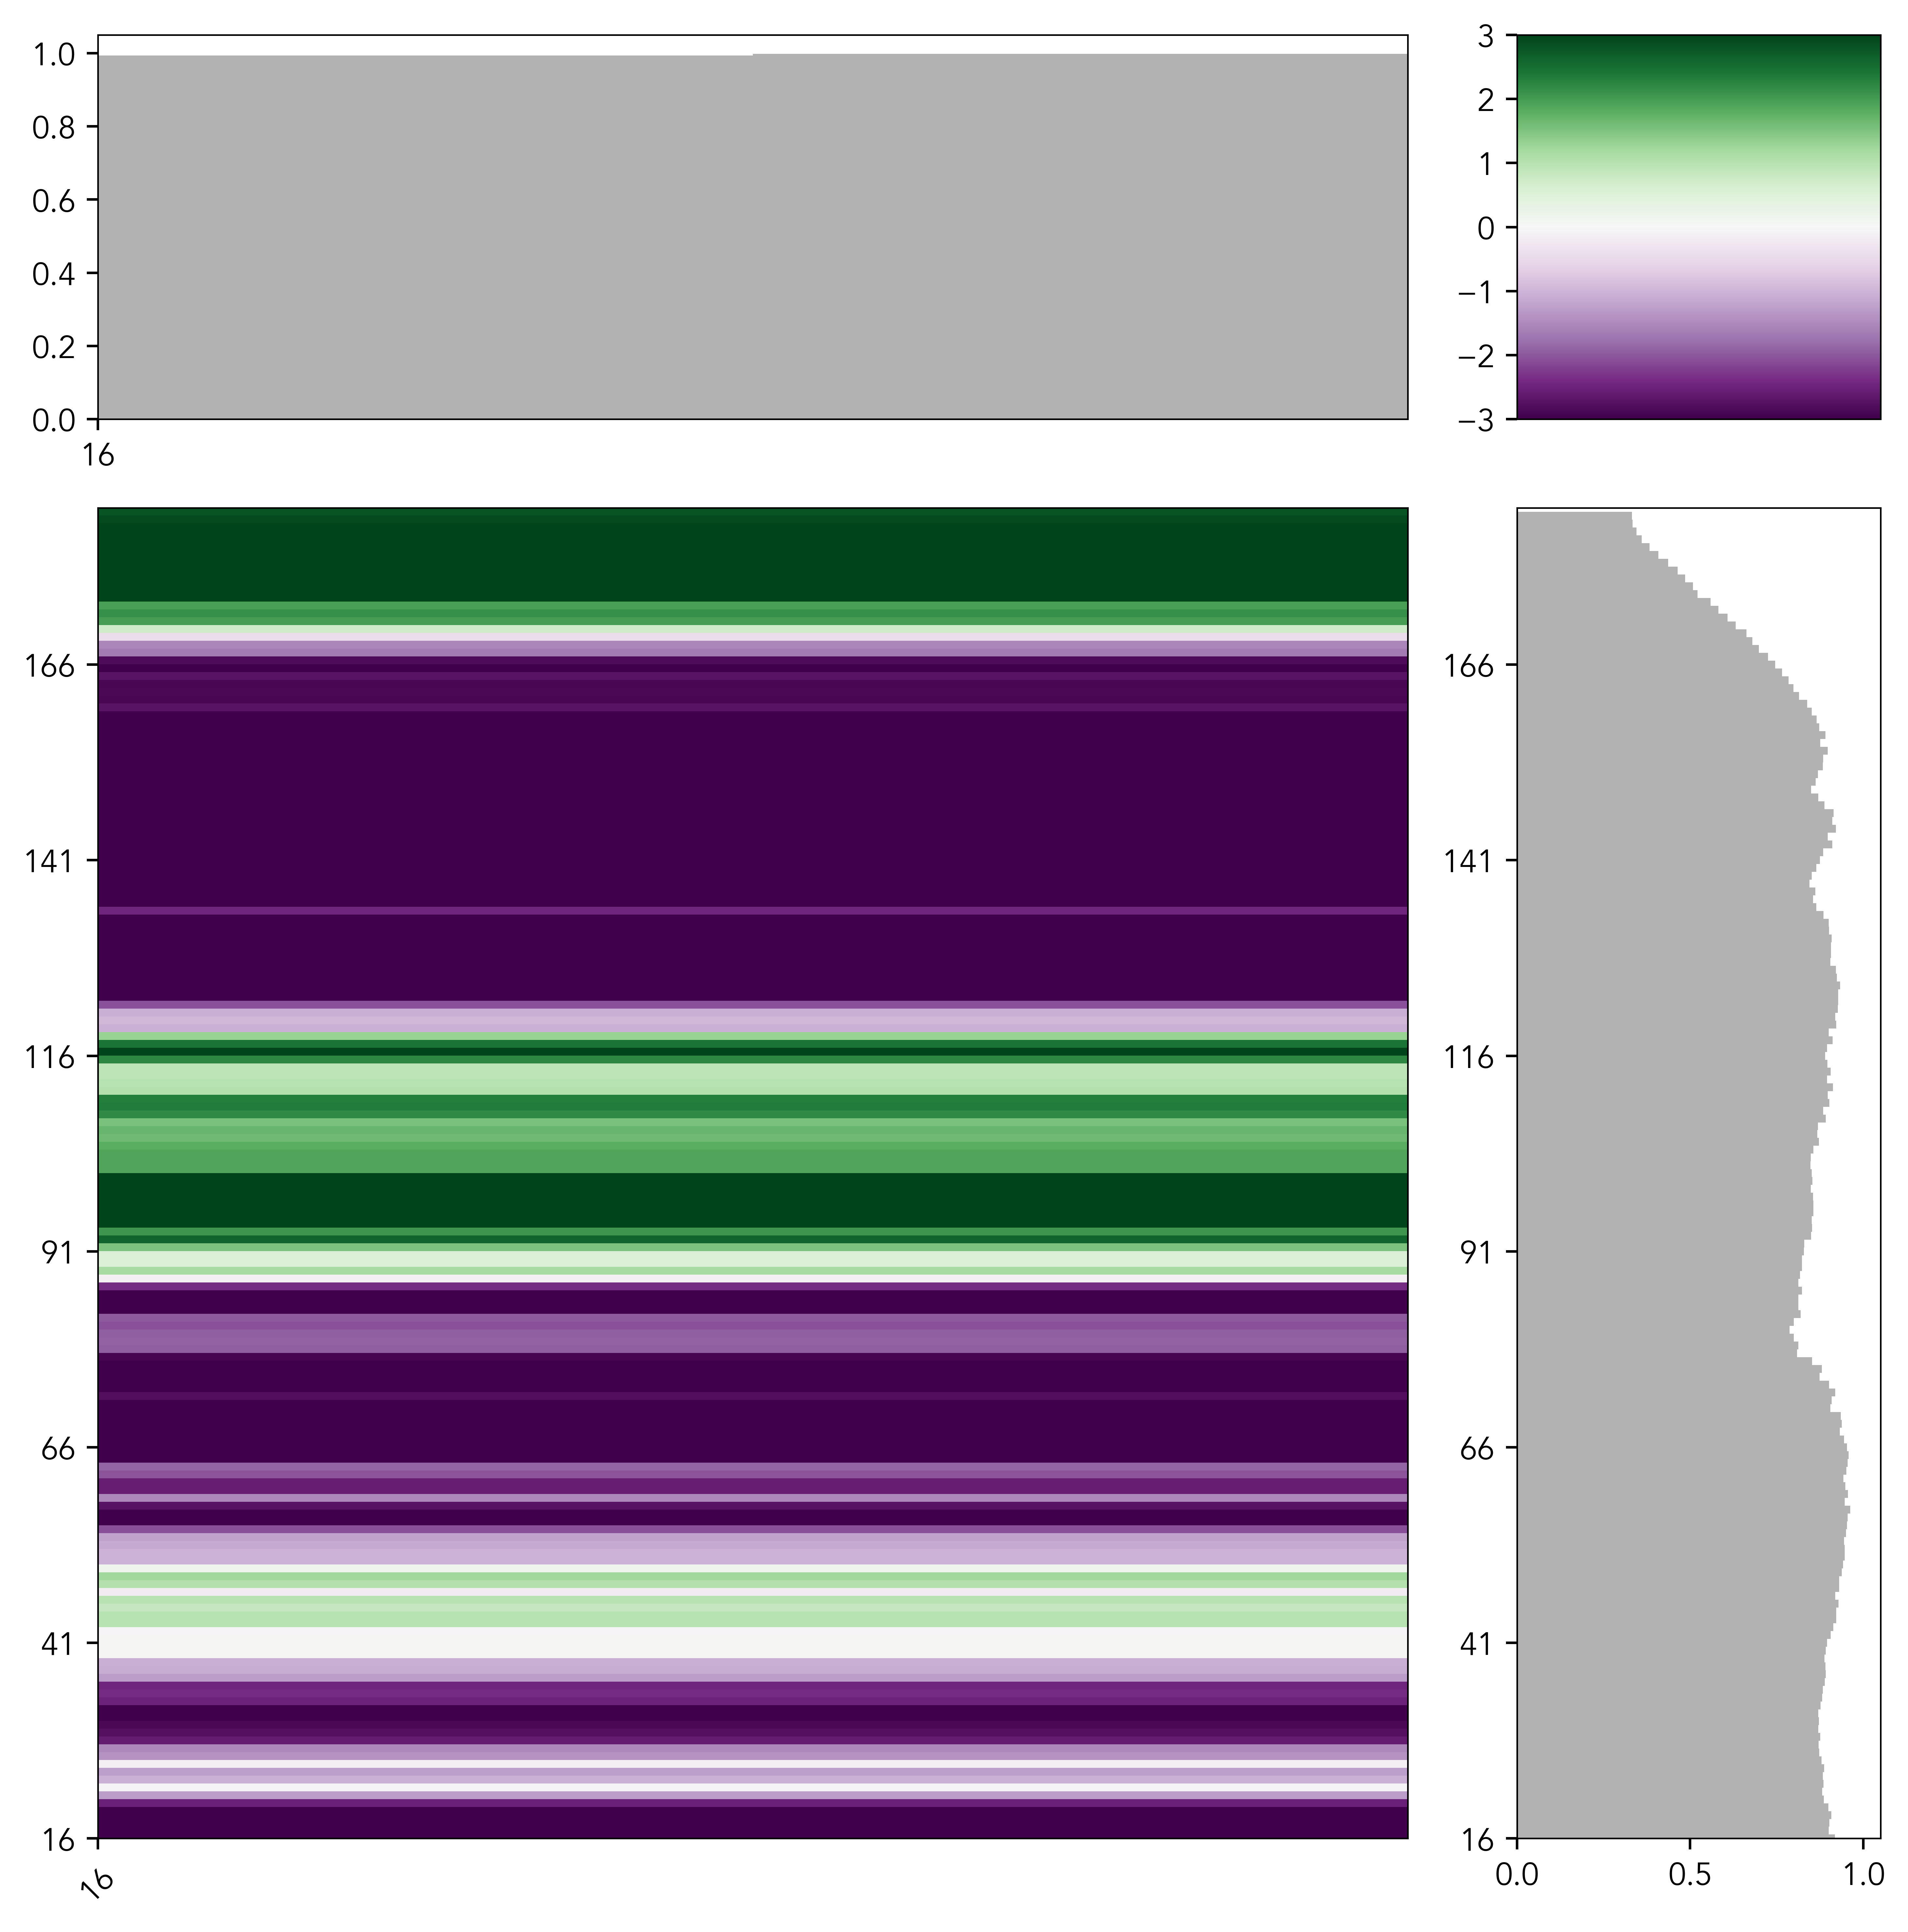

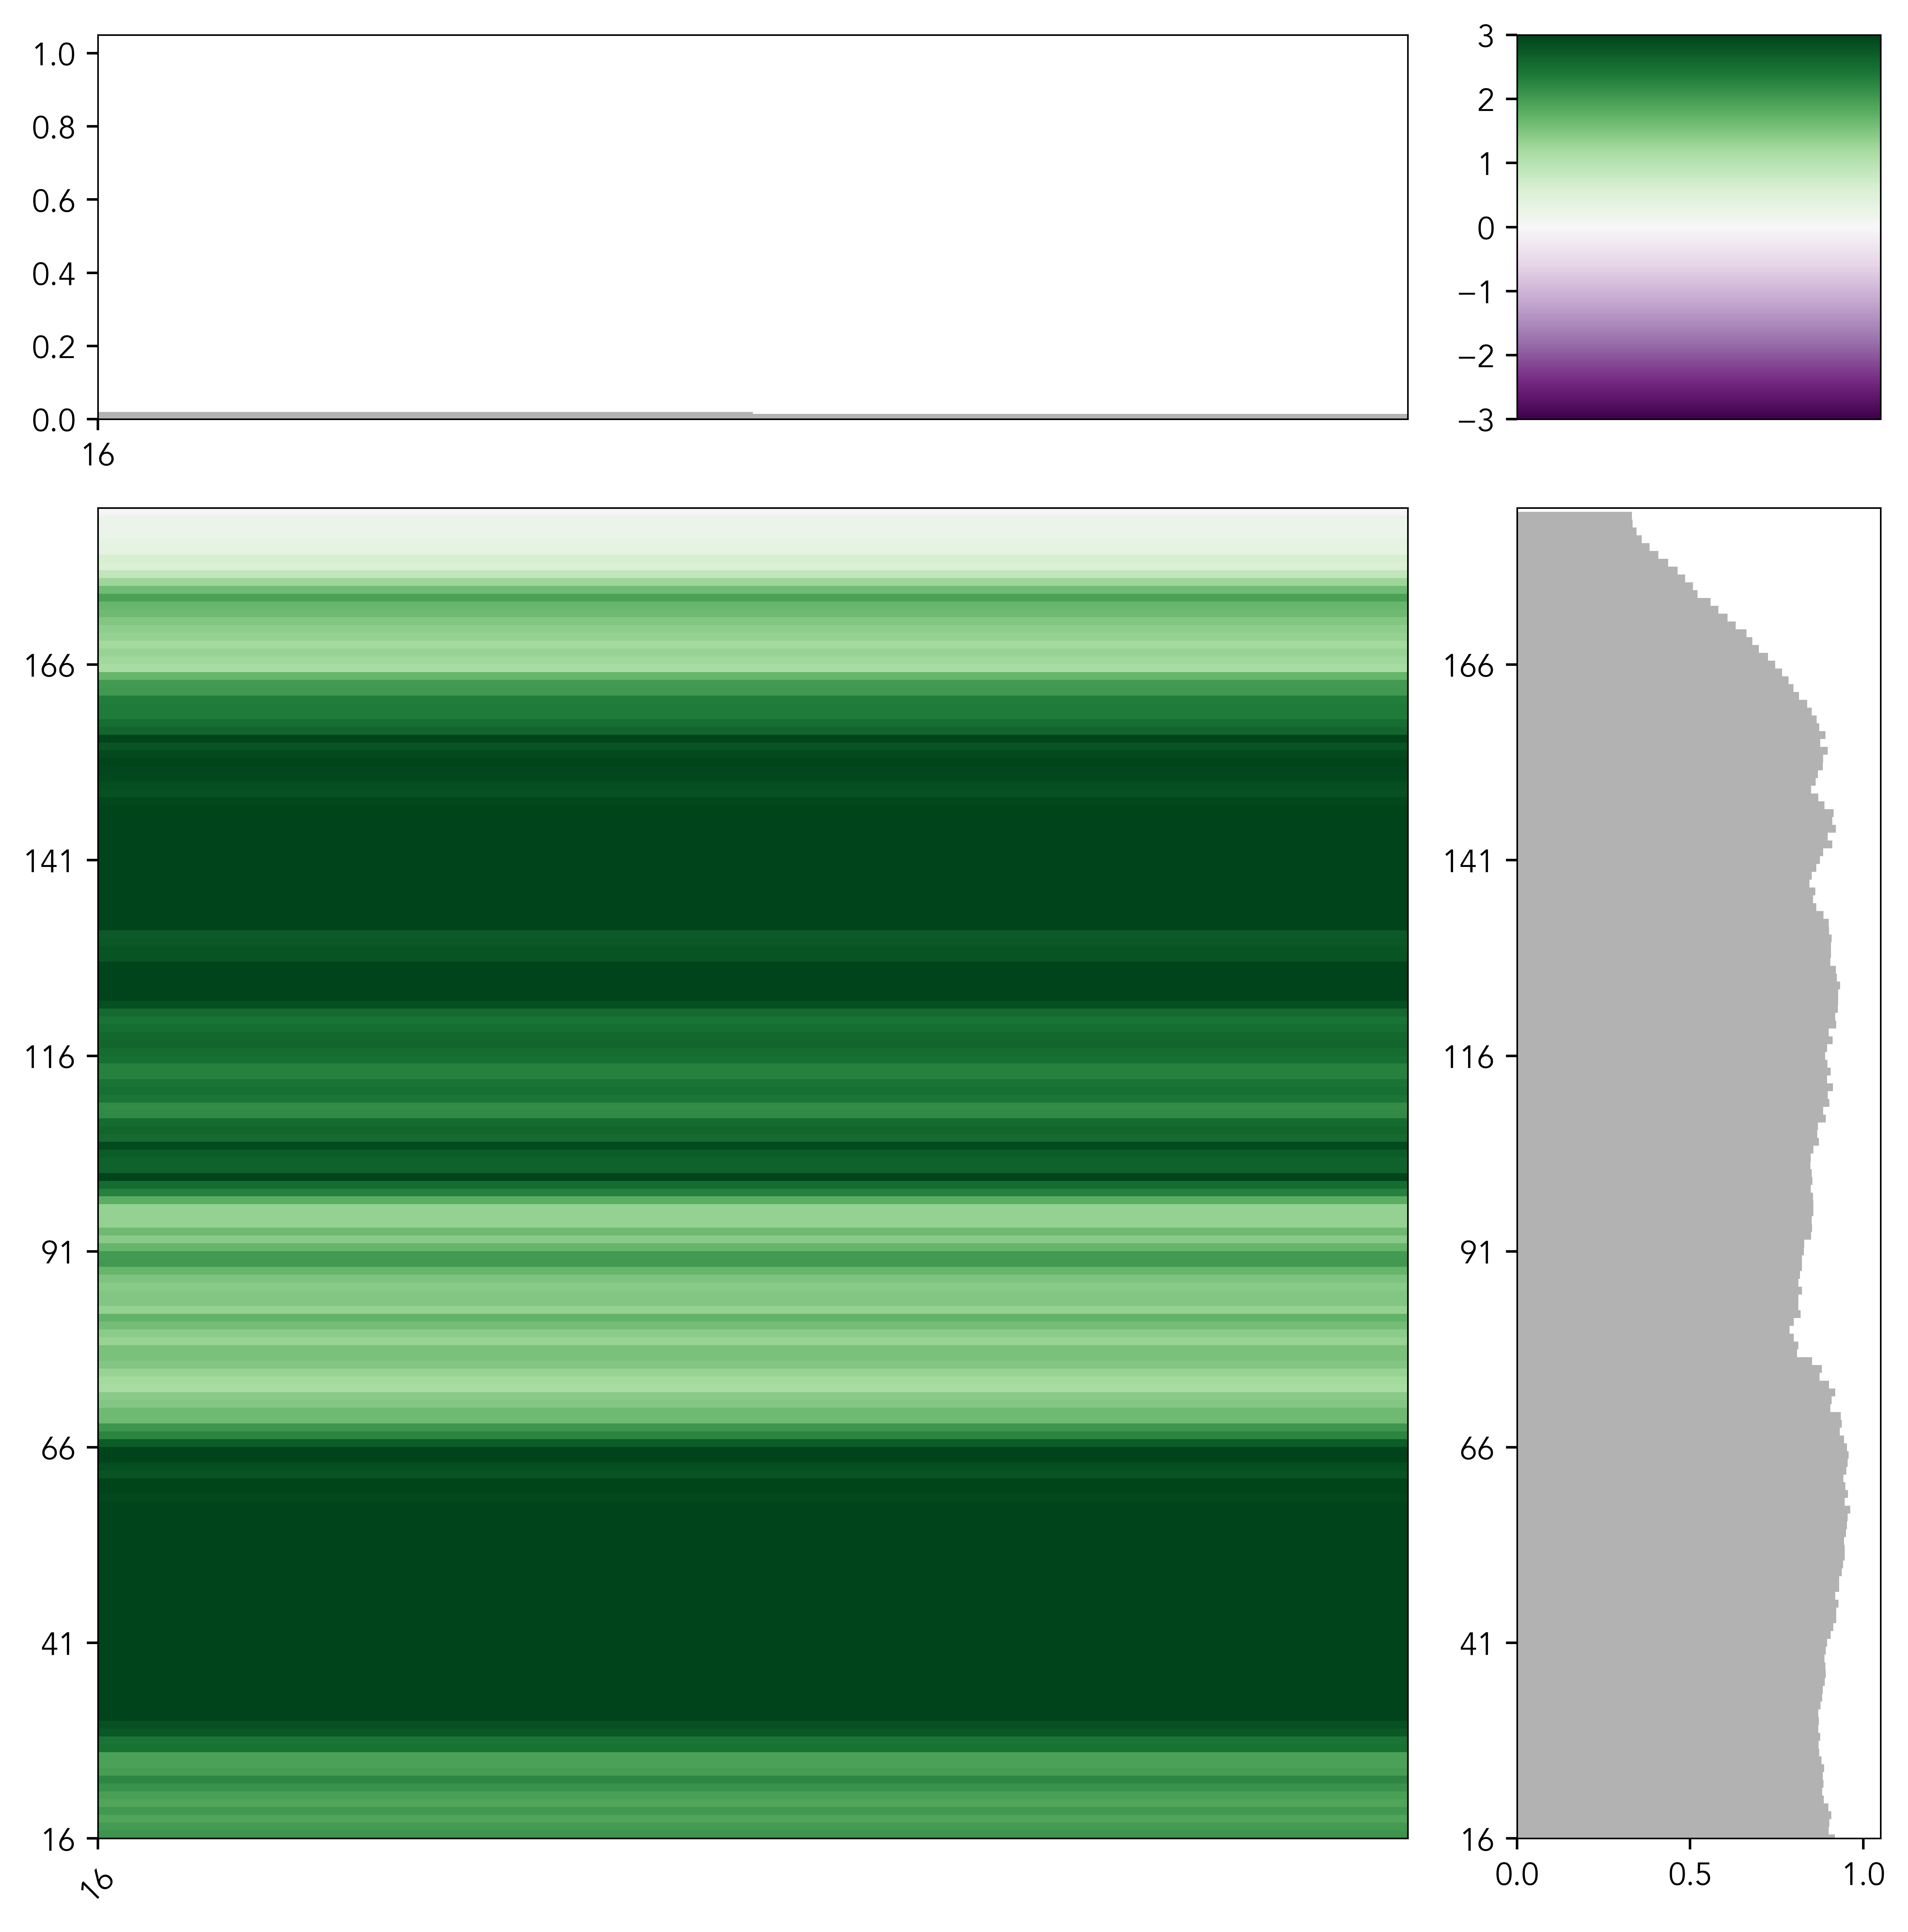

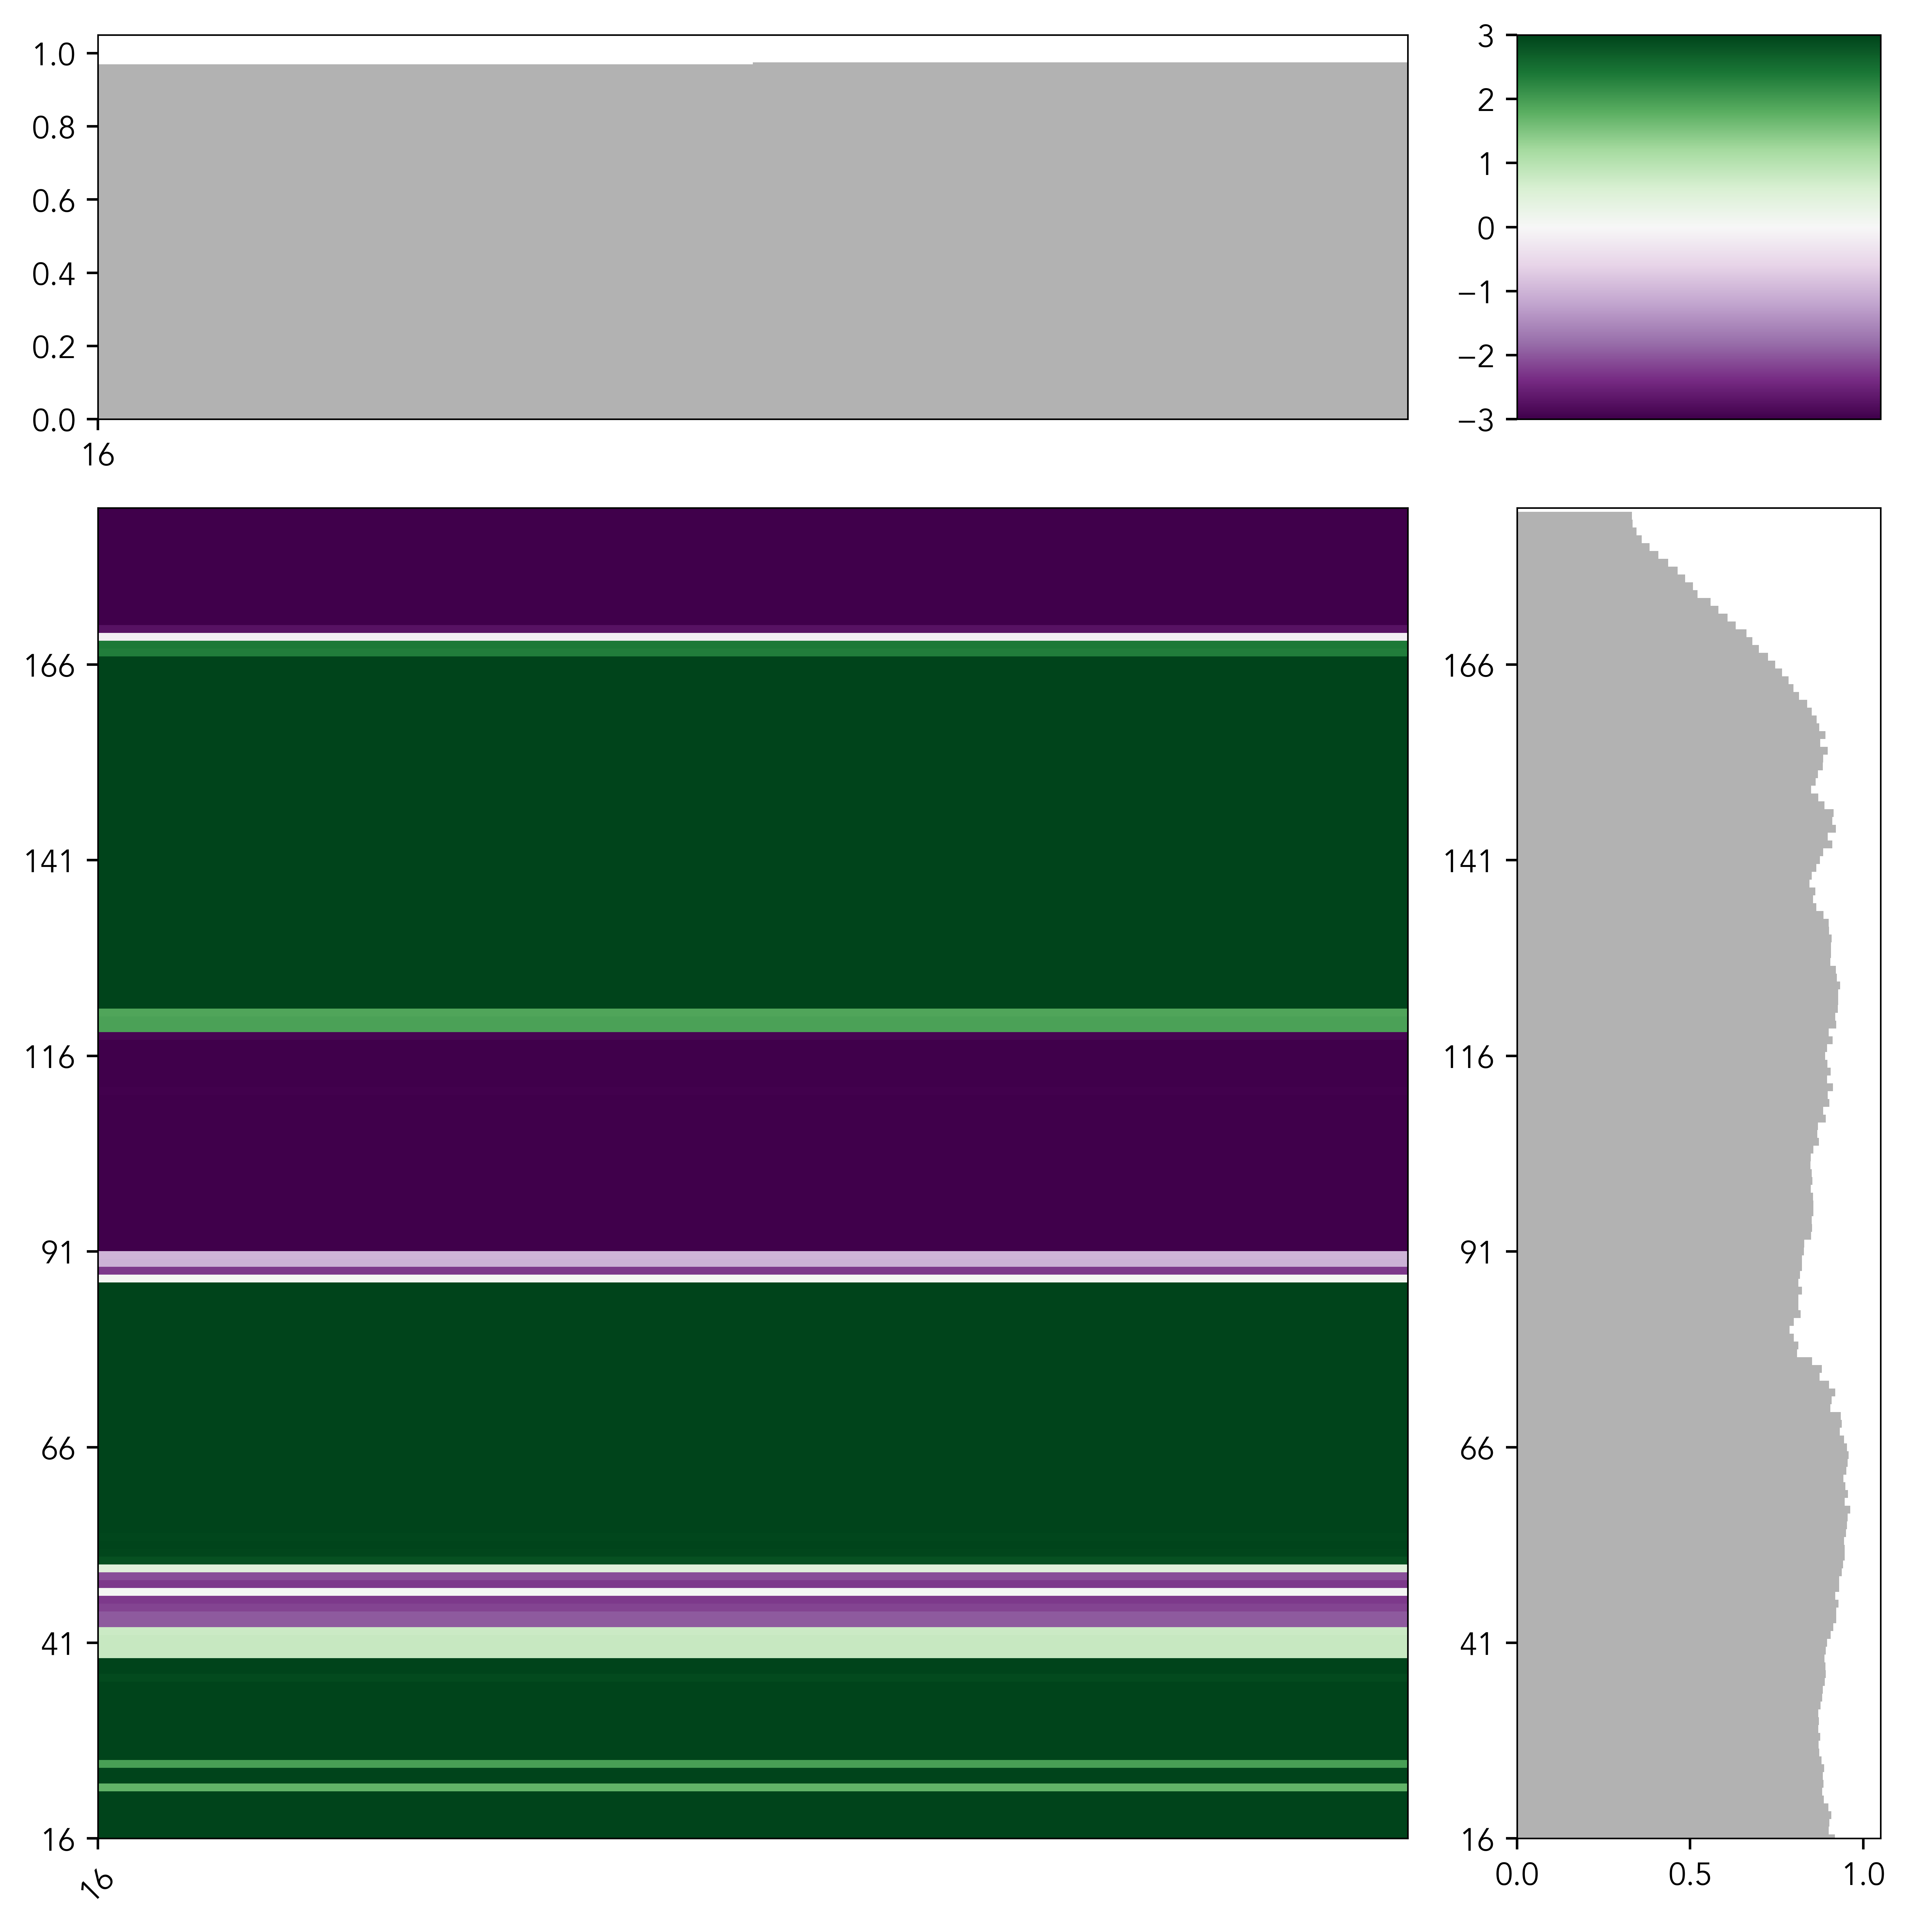

In [11]:
guest = 16*'RG'
mf.interaction_figure(guest, brca2_sub, fname='out_figures/brca2_sub_RG.pdf', tic_frequency=25,zero_folded=False)

guest = 16*'LL'
mf.interaction_figure(guest, brca2_sub, fname='out_figures/brca2_sub_LL.pdf', tic_frequency=25,zero_folded=False)

guest = 16*'ED'
mf.interaction_figure(guest, brca2_sub, fname='out_figures/brca2_sub_ED.pdf', tic_frequency=25,zero_folded=False)

IDR: 1-2556
IDR: 2699-2711
IDR: 3193-3418


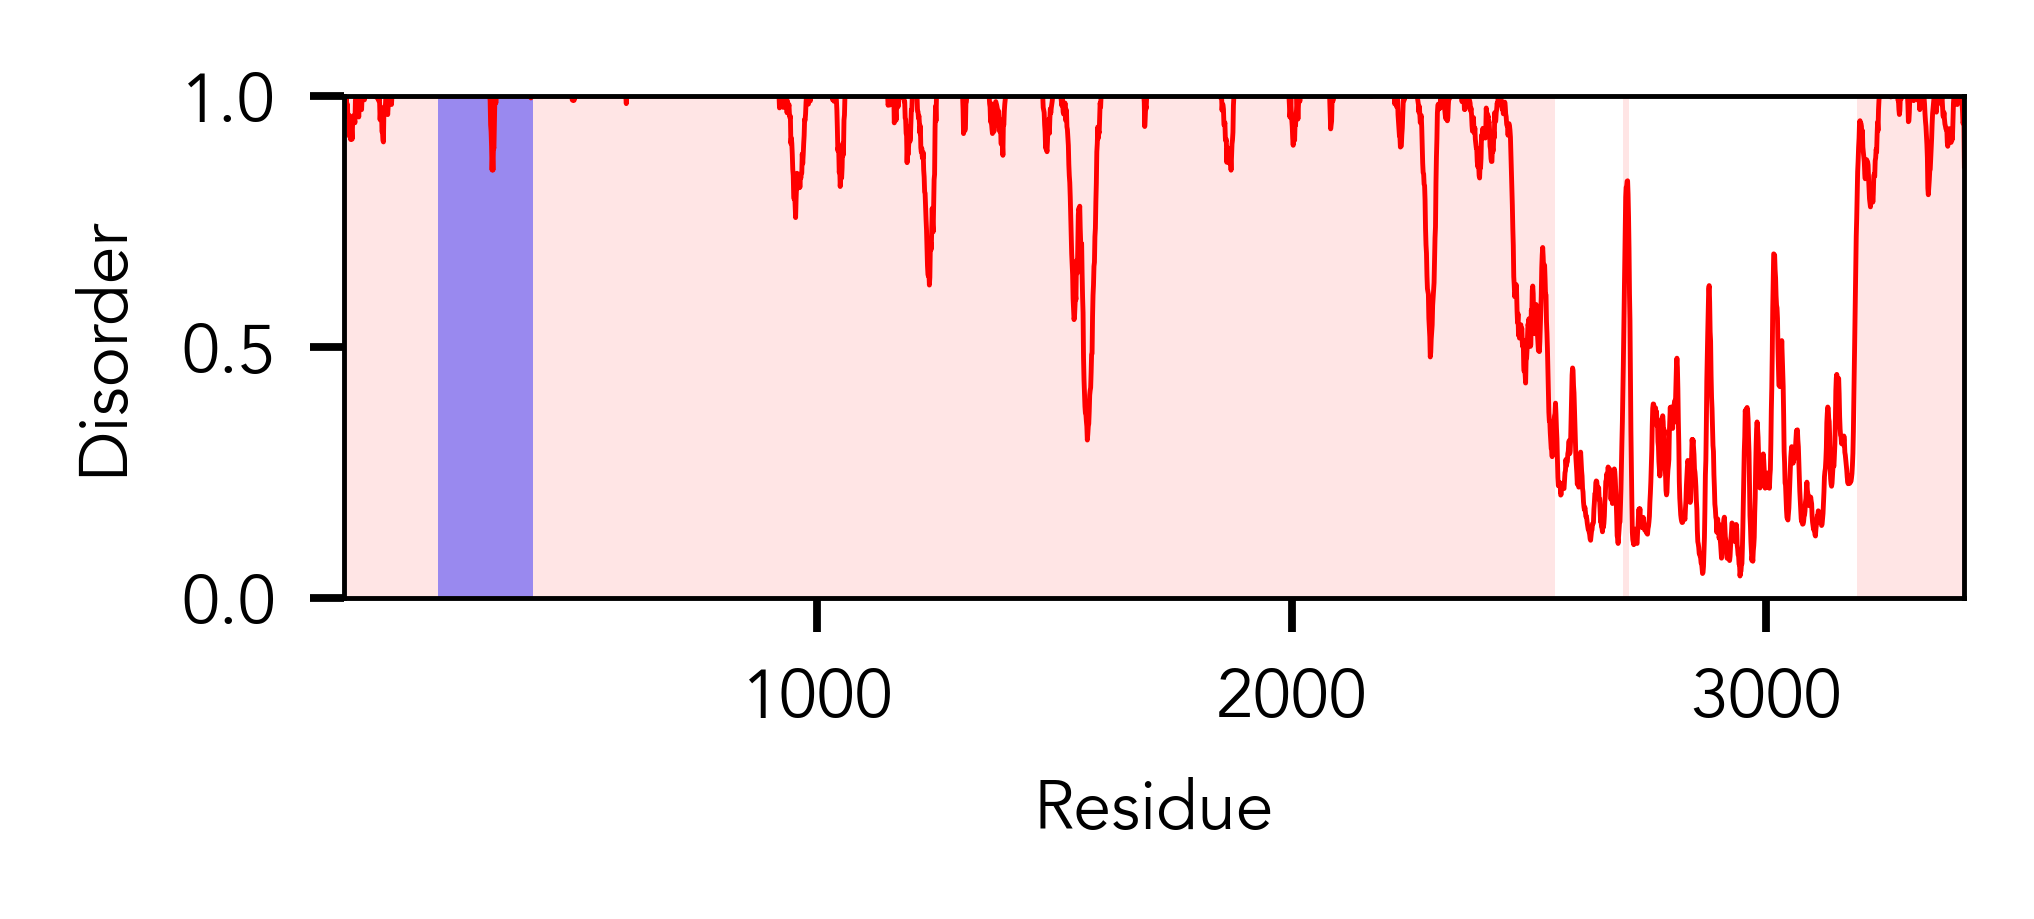

In [10]:
figure(None, (3,1.4), dpi=350)
ax = plt.gca()
seq = brca2
idx = np.arange(1,len(seq)+1)
plt.plot(idx, meta.predict_disorder(seq,version=2), color='r', lw=0.5)
doms = meta.predict_disorder_domains(seq)
for d in doms.disordered_domain_boundaries:
    print(f"IDR: {d[0]+1}-{d[1]}")
    ax.axvspan(d[0],d[1],lw=0, color='r', alpha=0.1)

ax.axvspan(200,400,color='b',lw=0,alpha=0.4)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.xlabel('Residue',fontsize=7)
plt.ylabel('Disorder',fontsize=7)
plt.ylim([0,1])
plt.xlim([1,idx[-1]])
plt.tight_layout()
plt.savefig('out_figures/disorder_brca2.pdf')